<h2> Importing Libraries </h2>

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=209737fa85461e0edc7dda93f62209e8e27540f973cd29f5c4786ae1adefd758
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

<h2> Helper Function </h2>

In [ ]:
def numerical_distribution(data, var_group):
  '''
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
    sns.distplot(data[i], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}).set(xlabel='No of {}'.format(i), ylabel='Count');
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; \nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

In [ ]:
def categorical(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize =(7*size,5), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    count = data[i].value_counts()
    n_unique = data[i].nunique()
    total = len(data[i])

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    ax = sns.barplot(count,count.index,order=count.index)
    plt.xlabel('fraction/percent',fontsize=20)
    plt.ylabel('{}'.format(i),fontsize=20)
  
    for p in ax.patches:
      percentage = '{:.1f}%'.format(100*p.get_width()/total)
      x = p.get_x() + p.get_width() + 0.02
      y = p.get_y() + p.get_height()/2
      ax.annotate(percentage, (x,y),fontsize=15)

<h2> Reading Data </h2>

In [ ]:
train = pd.read_csv("train_0OECtn8.csv")
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13


In [ ]:
train = train.drop(['row_id'], axis=1)


*   use of row id not allowed so drop it

*   heatmap to find correlation with target


*   interaction of features with each other?

*   outliers present kind of so how to handle?


*   Write efficient code


*   Is R2 score affected by outliers?











In [ ]:
test = pd.read_csv("test_1zqHu22.csv")
test.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views
0,89198,7986,12,42,14,Male,Student,180,138
1,89199,11278,34,115,14,Male,Student,230,840
2,89200,17245,8,110,44,Female,Working Professional,280,628
3,89201,9851,16,137,18,Male,Student,270,462
4,89202,16008,34,96,47,Female,Other,230,840


In [ ]:
test = test.drop(['row_id'], axis=1)

In [ ]:
train.shape

(89197, 9)

In [ ]:
test.shape

(11121, 8)

<h2> Checking for null values </h2>

In [ ]:
print("Train data has {} null values".format(train.isnull().sum().sum()))
print("Test data has {} null values".format(test.isnull().sum().sum()))

Train data has 0 null values
Test data has 0 null values


In [ ]:
train.profession.value_counts()

Student                 44638
Other                   26840
Working Professional    17719
Name: profession, dtype: int64

<h2> EDA </h2>
<h3> Target Variable </h3>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


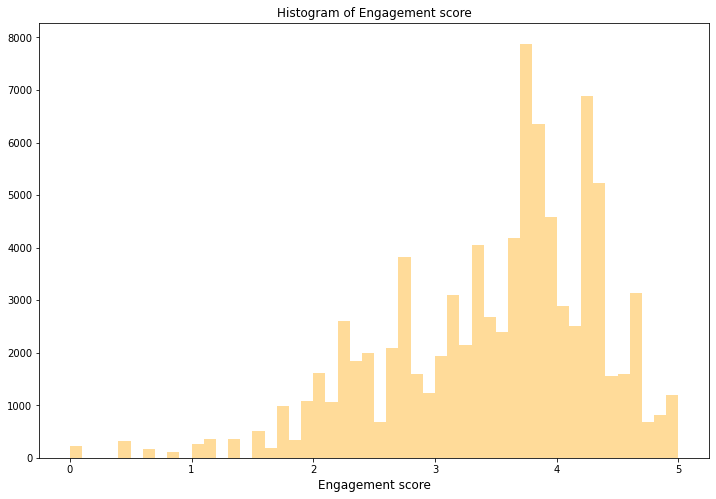

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(train['engagement_score'].values,bins=50,kde=False,color="orange")
plt.title("Histogram of Engagement score")
plt.xlabel('Engagement score',fontsize=12)
plt.show()

In [ ]:
train.engagement_score.mean()

3.487797011110046

In [ ]:
train.engagement_score.min(), train.engagement_score.max()

(0.0, 5.0)

The target variable is having high variance as the range of values of score are far apart from the mean of the feature. As the count of scores between 0 to 1 are very few, lets treat them as outliers. But for starters we will not touch the outliers as it is important with respect to our target variable. Just for our knowledge, lets see how many percent of videos/content has less than 1 score. 

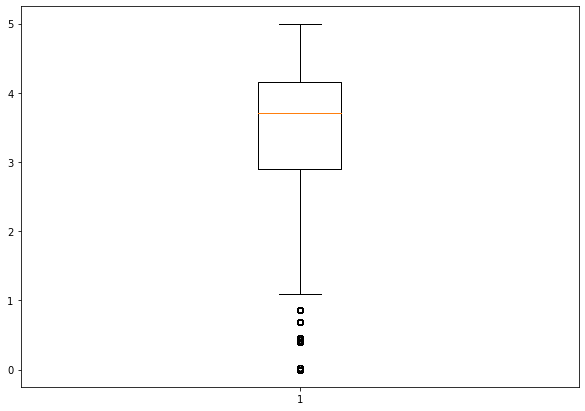

In [ ]:
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(train['engagement_score'])
 
# show plot
plt.show()

Looking at the boxplot, we can say there are outliers present in our data.

In [ ]:
(train['engagement_score']<1).sum()

820

In [ ]:
p = np.round((train['engagement_score']<1).sum()/train.shape[0],2)
print("There are {}% of outliers present in our data.".format(p*100))

There are 1.0% of outliers present in our data.


<h2> 1. Univariate Analysis </h2>
<h3> Train Data </h3>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


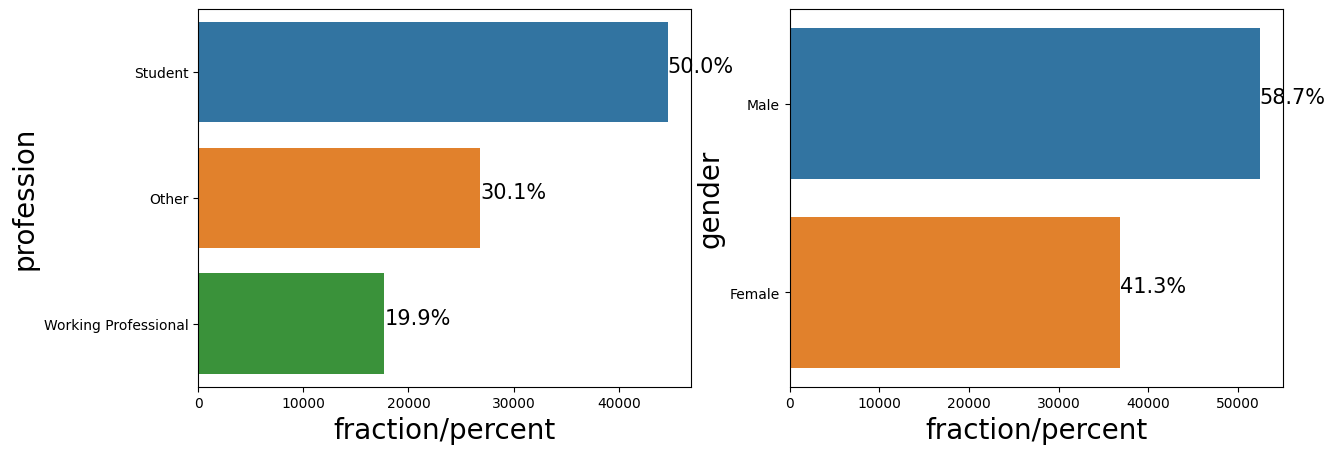

In [ ]:
categorical(train, ['profession', 'gender'])

**Profession-**
* Looking at the chart we found out that, Students are the most active users of ABC platform, followed by other type of users, and working professionals have the least count.
* Engagement percentage of all three - Student - 50%, Other - 30.1%, Working professional - 19.9%

**Gender-**
* Looking at the chart we found out that, ABS hase male users (58.7%) more than female users (41.3%) are the most active users of ABC platform.
                                                     

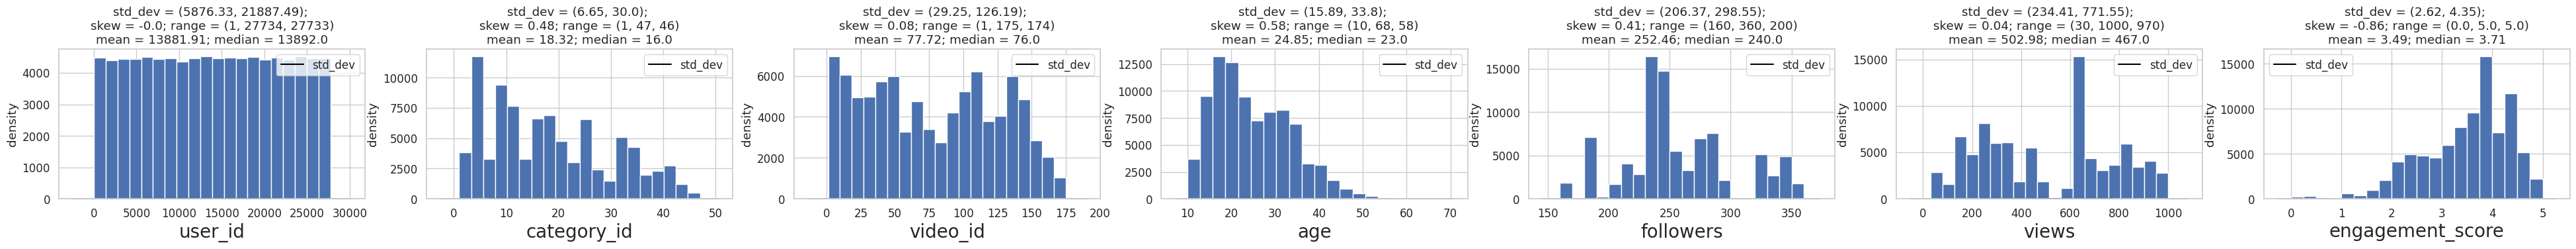

In [ ]:
numerical_distribution(train, ['user_id', 'category_id', 'video_id', 'age', 'followers', 'views', 'engagement_score'])


**User Id-**
*   Variable is unique for every customer, Hence uniform plot.
*   This variable does not contribute any information

**Category Id-**
* We have categories ranging from 1 to 47, with some categories more enjoyed by people than others.

**Video Id-**
* We have videos ranging from 1 to 75
*Mean - 77.72

**Age-**
* The users age group is between 10 to around 68 of which people in their early 20's to engage more likely with the videos.

**Followers-**
* A person has minimum of 160 and maximum of 360 followers.
* On an average a person has 252 followers.

**Views-**
* The most popular videos tend to get 1000 views and least that a video got is 30 views.
* Mean = 502.98

**Engagement Score-**
* There are few outliers present in our target variable.
* skewness : -0.86 - this is left skewed.

<h3> Test Data </h3>
<h3> Categorical features </h3>

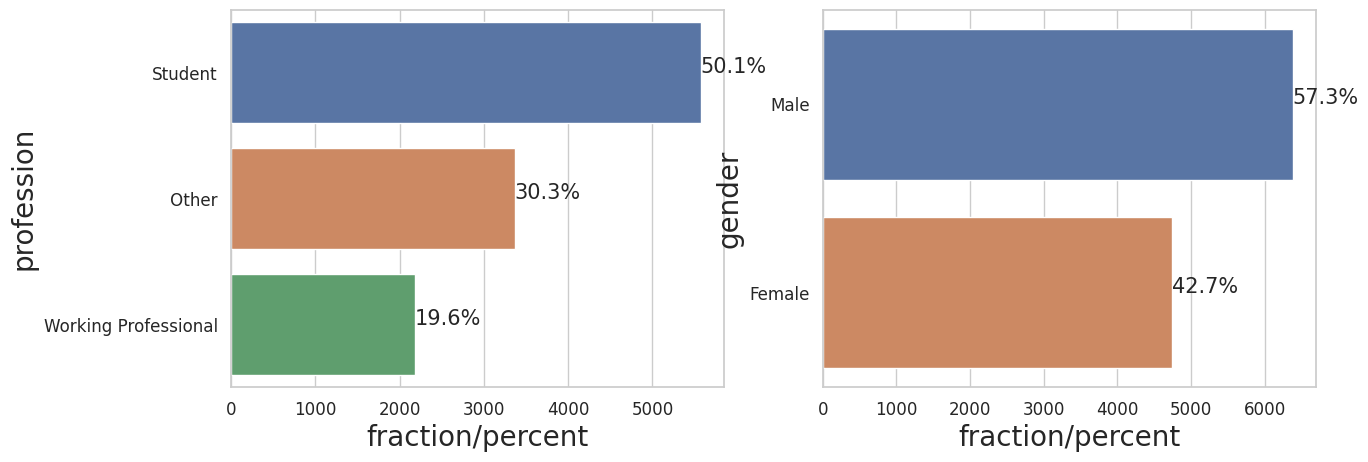

In [ ]:
categorical(test, ['profession', 'gender'])

**Profession-**
* Looking at the chart we found out that, Students are the most active users of ABC platform, followed by other type of users, and working professionals have the least count.
* Engagement percentage of all three - Student - 50.1%, Other - 30.3%, Working professional - 19.6%

**Gender-**
* Looking at the chart we found out that, ABS hase male users (57.3%) more than female users (42.7%) are the most active users of ABC platform.

<h3> Numerical Features </h3>

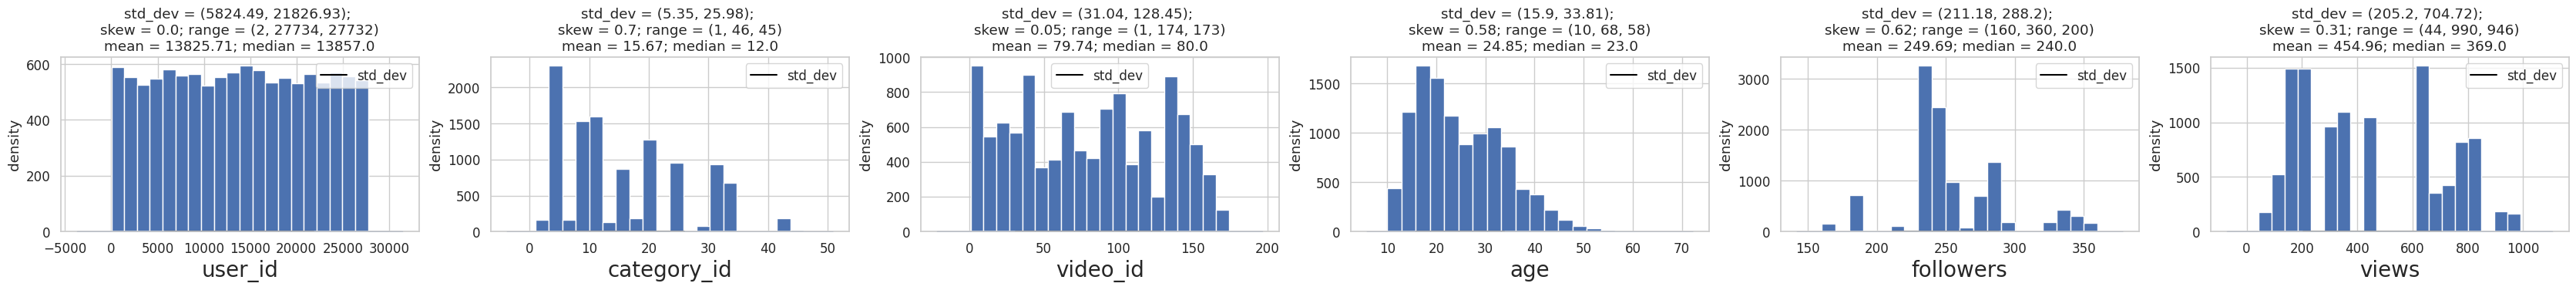

In [ ]:
numerical_distribution(test, ['user_id', 'category_id', 'video_id', 'age', 'followers', 'views'])

**User Id-**
*   Variable is unique for every customer, Hence uniform plot.
*   This variable does not contribute any information

**Category Id-**
* We have categories ranging from 1 to 46, with some categories more enjoyed by people than others.

**Video Id-**
* We have videos ranging from 1 to 174
*Mean - 79.74

**Age-**
* The users age group is between 10 to around 68 of which teenagers (15-20 age group) to engage more likely with the videos.

**Followers-**
* A person has minimum of 160 and maximum of 360 followers.
* On an average a person has 250 followers approx.

**Views-**
* The most popular videos tend to get 990 views and least that a video got is 44 views.
* Mean = 455 approx


<h2> Bivariate Analysis </h2>
<h3> Train Data </h3>
<h3> Categorical Variable </h3>

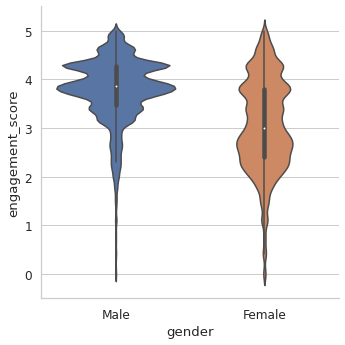

In [ ]:
fig = sns.catplot(y="engagement_score", x = "gender", kind='violin', data=train)

The males are more active on the platform than Females

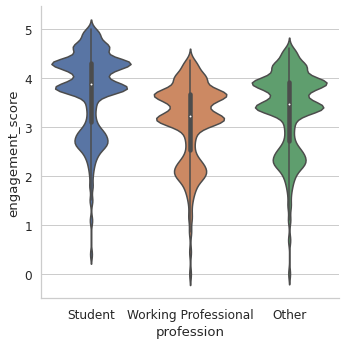

In [ ]:
fig = sns.catplot(y="engagement_score", x = "profession", kind='violin', data=train)

Students seem to engage more with videoss than other categories.

<h3> Numerical Variable </h3>

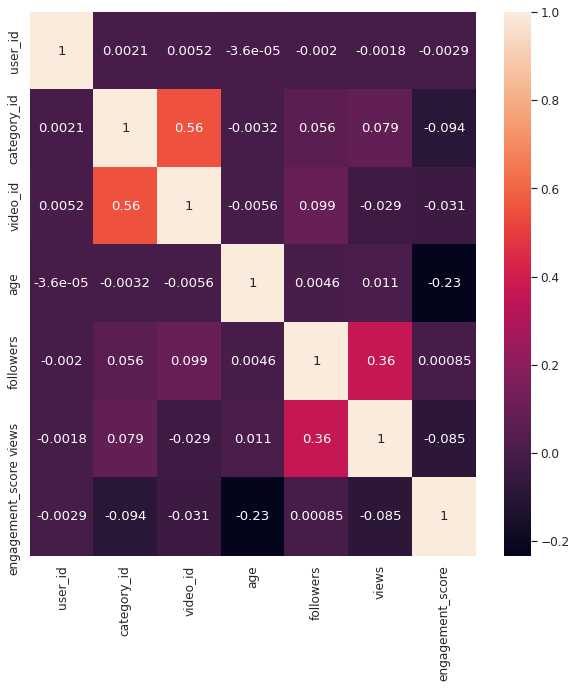

In [ ]:
Var_Corr = train.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(Var_Corr, xticklabels = Var_Corr.columns, yticklabels = Var_Corr.columns, annot =True)

**Variable Interactions :** 
* Features **video_id** and **category_id** are highly correlated to each other.
* Next, features **views** and **followers** are correlated to each other.
* Looking at our target variable engagement_score, **none of the features** user_id, category_id, video_id, followers, or views **are correlated to the target variable**.
* Therefore, we need to do some **feature engineering to create correlated features** which will help us to predict engagement score feature using machine learning.

In [ ]:
#Preprocessing the data
train['gender'] = train['gender'].map({'Female': 1,'Male': 0})
train['profession'] = train['profession'].map({"Student": 0, "Other": 1, "Working Professional": 2})

test['gender'] = test['gender'].map({'Female': 1,'Male': 0})
test['profession'] = test['profession'].map({"Student": 0, "Other": 1, "Working Professional": 2})

<h2> Feature Engineering </h2>

<h2> Ratio of views per followers </h2>

In [ ]:
train['ratio_views'] = train['views']/train['followers']
test['ratio_views'] = test['views']/test['followers']

In [ ]:
agg2 = {
         'gender_0' : ['sum', 'mean', 'nunique'],
         'gender_1' : ['sum', 'mean', 'nunique'],
         'profession_0' : ['sum', 'mean', 'nunique'],
         'profession_1' : ['sum', 'mean', 'nunique'],
         'profession_2' : ['sum', 'mean', 'nunique'],
         'video_id' : ['sum', 'mean', 'max', 'min', 'median'],
         'category_id' : ['sum', 'mean', 'max', 'min', 'median'],
         'age' : ['mean', 'max', 'min', 'median'],
         'views' : ['sum', 'mean', 'max', 'min', 'median'],
         'followers' : ['sum', 'mean', 'max', 'min', 'median']
     }


In [ ]:
def aggregated_transactional2(df):
    df_new = df.groupby(['user_id']).agg(agg2)
    #print(df_new)
    
    temp_array = df_new.columns.values
    df_new.columns = ['_'.join(col).strip() for col in temp_array]
   # print(df_new.columns)
    df_new.reset_index(inplace=True)
    
    df = df.drop(['gender_0', 'gender_1', 'profession_0', 'profession_1', 'profession_2', 'category_id', 'video_id', 'age', 'followers', 'views'], axis = 1)
    df = pd.merge_asof(df.sort_values("user_id"), df_new, on='user_id')
    return df

In [ ]:
%%time
res = pd.get_dummies(train, columns = ['gender', 'profession'])

CPU times: user 23.5 ms, sys: 3.01 ms, total: 26.5 ms
Wall time: 26.2 ms


In [ ]:
res.columns

Index(['user_id', 'category_id', 'video_id', 'age', 'followers', 'views',
       'engagement_score', 'ratio_views', 'gender_0', 'gender_1',
       'profession_0', 'profession_1', 'profession_2'],
      dtype='object')

In [ ]:
%%time
train = aggregated_transactional2(res)

CPU times: user 305 ms, sys: 4.01 ms, total: 309 ms
Wall time: 309 ms


In [ ]:
train.columns

Index(['user_id', 'engagement_score', 'ratio_views', 'gender_0_sum',
       'gender_0_mean', 'gender_0_nunique', 'gender_1_sum', 'gender_1_mean',
       'gender_1_nunique', 'profession_0_sum', 'profession_0_mean',
       'profession_0_nunique', 'profession_1_sum', 'profession_1_mean',
       'profession_1_nunique', 'profession_2_sum', 'profession_2_mean',
       'profession_2_nunique', 'video_id_sum', 'video_id_mean', 'video_id_max',
       'video_id_min', 'video_id_median', 'category_id_sum',
       'category_id_mean', 'category_id_max', 'category_id_min',
       'category_id_median', 'age_mean', 'age_max', 'age_min', 'age_median',
       'views_sum', 'views_mean', 'views_max', 'views_min', 'views_median',
       'followers_sum', 'followers_mean', 'followers_max', 'followers_min',
       'followers_median'],
      dtype='object')

In [ ]:
%%time
res = pd.get_dummies(test, columns = ['gender', 'profession'])

CPU times: user 8.59 ms, sys: 3 µs, total: 8.59 ms
Wall time: 9.74 ms


In [ ]:
%%time
test = aggregated_transactional2(res)

CPU times: user 81.5 ms, sys: 3 µs, total: 81.5 ms
Wall time: 83.2 ms


<h2> Successive Aggregated </h2>

In [ ]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['user_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('user_id')[field2].agg(['mean', 'min', 'max', 'sum'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [ ]:
#train data
tr_additional_fields = successive_aggregates(res, 'video_id', 'views')
tr_additional_fields = tr_additional_fields.merge(successive_aggregates(res, 'category_id', 'views'),
                                            on = 'user_id', how='left')
tr_additional_fields = tr_additional_fields.merge(successive_aggregates(res, 'video_id', 'followers'),
                                            on = 'user_id', how='left')
tr_additional_fields = tr_additional_fields.merge(successive_aggregates(res, 'category_id', 'followers'),
                                            on = 'user_id', how='left')

In [ ]:
#test data
te_additional_fields = successive_aggregates(res, 'video_id', 'views')
te_additional_fields = te_additional_fields.merge(successive_aggregates(res, 'category_id', 'views'),
                                            on = 'user_id', how='left')
te_additional_fields = te_additional_fields.merge(successive_aggregates(res, 'video_id', 'followers'),
                                            on = 'user_id', how='left')
te_additional_fields = te_additional_fields.merge(successive_aggregates(res, 'category_id', 'followers'),
                                            on = 'user_id', how='left')

In [ ]:
#merge with train data
train = train.merge(te_additional_fields, on = 'user_id', how = 'left')
test = test.merge(te_additional_fields, on = 'user_id', how = 'left')

<h2> Checking for null values </h2>

In [ ]:
train.isnull().sum()

user_id                           0
ratio_views                       0
gender_0_sum                      0
gender_0_mean                     0
gender_0_nunique                  0
gender_1_sum                      0
gender_1_mean                     0
gender_1_nunique                  0
profession_0_sum                  0
profession_0_mean                 0
profession_0_nunique              0
profession_1_sum                  0
profession_1_mean                 0
profession_1_nunique              0
profession_2_sum                  0
profession_2_mean                 0
profession_2_nunique              0
video_id_sum                      0
video_id_mean                     0
video_id_max                      0
video_id_min                      0
video_id_median                   0
category_id_sum                   0
category_id_mean                  0
category_id_max                   0
category_id_min                   0
category_id_median                0
age_mean                    

In [ ]:
train = train.fillna(method = 'bfill')

In [ ]:
test.isnull().sum()

user_id                       0
ratio_views                   0
gender_0_sum                  0
gender_0_mean                 0
gender_0_nunique              0
gender_1_sum                  0
gender_1_mean                 0
gender_1_nunique              0
profession_0_sum              0
profession_0_mean             0
profession_0_nunique          0
profession_1_sum              0
profession_1_mean             0
profession_1_nunique          0
profession_2_sum              0
profession_2_mean             0
profession_2_nunique          0
video_id_sum                  0
video_id_mean                 0
video_id_max                  0
video_id_min                  0
video_id_median               0
category_id_sum               0
category_id_mean              0
category_id_max               0
category_id_min               0
category_id_median            0
age_mean                      0
age_max                       0
age_min                       0
age_median                    0
views_su

<h2> Normalizing data </h2>

In [ ]:
y_train = train['engagement_score']
train = train.drop(['engagement_score'], axis=1)

In [ ]:
#cat_features=[col for col in X.columns if X[col].dtype=='object']
num_features = [col for col in train.columns if train[col].dtype in ("int64", "float64")]

print("NORMALIZING NUMERICAL FEATURES:")
for feature in num_features:
    print(feature)
    normalizer = Normalizer()
    train[feature] =normalizer.fit_transform(train[feature].values.reshape(-1,1))
    test[feature] = normalizer.transform(test[feature].values.reshape(-1,1))
    print(f" {feature} done ")
    print("="*127)

NORMALIZING NUMERICAL FEATURES:
user_id
 user_id done 
ratio_views
 ratio_views done 
gender_0_mean
 gender_0_mean done 
gender_0_nunique
 gender_0_nunique done 
gender_1_mean
 gender_1_mean done 
gender_1_nunique
 gender_1_nunique done 
profession_0_mean
 profession_0_mean done 
profession_0_nunique
 profession_0_nunique done 
profession_1_mean
 profession_1_mean done 
profession_1_nunique
 profession_1_nunique done 
profession_2_mean
 profession_2_mean done 
profession_2_nunique
 profession_2_nunique done 
video_id_sum
 video_id_sum done 
video_id_mean
 video_id_mean done 
video_id_max
 video_id_max done 
video_id_min
 video_id_min done 
video_id_median
 video_id_median done 
category_id_sum
 category_id_sum done 
category_id_mean
 category_id_mean done 
category_id_max
 category_id_max done 
category_id_min
 category_id_min done 
category_id_median
 category_id_median done 
age_mean
 age_mean done 
age_max
 age_max done 
age_min
 age_min done 
age_median
 age_median done 
views_sum


<h2> Modeling : With Outliers </h2>
<h3> 1. Baseline Model: Random Forest </h3>

In [ ]:
def r2(y_true, y_pred):
  correlation_matrix = np.corrcoef(y_true, y_pred)
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2
  return r_squared

In [ ]:
%%time
# Create a random forest classifier
random = RandomForestRegressor()
parameters = {'min_samples_split': [5, 10, 100, 500],'max_depth': [1, 5, 10, 50], 'min_samples_leaf': [2,4,6,8], 'n_estimators':[10,20,30,40]}

clf = RandomizedSearchCV(random, parameters, cv = 10, scoring='r2', return_train_score=True)
clf.fit(train, y_train)

best_param = clf.best_params_
print("Best hyper parameter of decision tree is",best_param)

Best hyper parameter of decision tree is {'n_estimators': 40, 'min_samples_split': 500, 'min_samples_leaf': 4, 'max_depth': 50}
CPU times: user 1min 42s, sys: 576 ms, total: 1min 43s
Wall time: 1min 51s


In [ ]:
%%time
#Cheacking the performance on unseen data

clf = RandomForestRegressor(max_depth = 50, min_samples_split = 500, min_samples_leaf= 4, n_estimators= 40)
clf.fit(train, y_train)


#y_train_pred = batch_predict(clf, X_tr1)    
y_train_pred = clf.predict(train) 

r2_score = r2(y_train, y_train_pred)
print("Random Model gives {} score".format(r2_score))

Random Model gives 0.2682127728366188 score
CPU times: user 1.47 s, sys: 4.89 ms, total: 1.47 s
Wall time: 1.48 s


<h2> 2. XGBoost Model </h2>

In [ ]:
%%time
import xgboost as xgb

#xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# Create a random forest classifier
xgb_model = xgb.XGBRegressor()
parameters = {'min_samples_split': [5, 10, 100, 500],'max_depth': [1, 5, 10, 50], 'min_samples_leaf': [2,4,6,8], 'n_estimators':[10,100, 500, 1000]}

clf = RandomizedSearchCV(xgb_model, parameters, cv = 10, scoring='r2', return_train_score=True)
clf.fit(train, y_train)

best_param = clf.best_params_
print("Best hyper parameter of decision tree is",best_param)

[15:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
%%time
#Cheacking the performance on unseen data

clf = xgb.XGBRegressor(max_depth = 1, min_samples_split = 100, min_samples_leaf= 8, n_estimators=1000)
clf.fit(train, y_train)


#y_train_pred = batch_predict(clf, X_tr1)    
y_train_pred = clf.predict(train) 

r2_score = r2(y_train, y_train_pred)
print("XGBoost Model gives {} score".format(r2_score))

[17:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Model gives 0.2679576281647671 score
CPU times: user 1min 1s, sys: 102 ms, total: 1min 2s
Wall time: 1min 1s


<h2> Modeling : Without outliers </h2>

Lets see if dropping the outliers affects the score.

In [ ]:
train = pd.read_csv("train_0OECtn8.csv")
train = train.drop(['row_id'], axis=1)
train = train[train['engagement_score']>1]

In [ ]:
test = pd.read_csv("test_1zqHu22.csv")
test = test.drop(['row_id'], axis=1)

I performed pre-processing and normalization from above code.

<h2> 1. Random Forest </h2>

In [ ]:
%%time
# Create a random forest classifier
random = RandomForestRegressor()
parameters = {'min_samples_split': [5, 10, 100, 500],'max_depth': [1, 5, 10, 50], 'min_samples_leaf': [2,4,6,8], 'n_estimators':[10,20,30,40]}

clf = RandomizedSearchCV(random, parameters, cv = 10, scoring='r2', return_train_score=True)
clf.fit(train, y_train)

best_param = clf.best_params_
print("Best hyper parameter of decision tree is",best_param)

Best hyper parameter of decision tree is {'n_estimators': 10, 'min_samples_split': 500, 'min_samples_leaf': 8, 'max_depth': 5}
CPU times: user 57.3 s, sys: 322 ms, total: 57.7 s
Wall time: 58.4 s


In [ ]:
%%time
#Cheacking the performance on unseen data

clf = RandomForestRegressor(max_depth = 5, min_samples_split = 500, min_samples_leaf= 8, n_estimators= 10)
clf.fit(train, y_train)


#y_train_pred = batch_predict(clf, X_tr1)    
y_train_pred = clf.predict(train) 

r2_score = r2(y_train, y_train_pred)
print("Random Model gives {} score".format(r2_score))

Random Model gives 0.2719491662293382 score
CPU times: user 729 ms, sys: 2.98 ms, total: 732 ms
Wall time: 802 ms


Removing outliers did improve my result, however, dropping outliers completely might lead to loss of information, so, I will be trying different approach. The lowest possible data point in the boxplot that has proper score assigned to it is the bar at the bottom of the box plot. All the point below it are considered as outliers. I will replace outlier score with the bottom bar value. As it will still count as the video got low engagement score, and we won't have to drop it compelety.

In [ ]:
train = pd.read_csv("train_0OECtn8.csv")
train = train.drop(['row_id'], axis=1)

test = pd.read_csv("test_1zqHu22.csv")
test = test.drop(['row_id'], axis=1)

In [ ]:
Q1 = np.percentile(train['engagement_score'], 25)
Q3 = np.percentile(train['engagement_score'], 75)
IQR = Q3-Q1

Lowest_score  = (Q1 - 1.5 * IQR)
print("Lowest proper engagement scores is {}".format(Lowest_score))

Lowest proper engagement scores is 1.0250000000000004


Lets replace all outliers with the 1.025 score.

In [ ]:
train.loc[train["engagement_score"] < 1, "engagement_score"] = 1.0250000000000004

<h2> Modeling : After treating the outliers </h2>

In [ ]:
%%time
# Create a random forest classifier
random = RandomForestRegressor()
parameters = {'min_samples_split': [5, 10, 100, 500],'max_depth': [1, 5, 10, 50], 'min_samples_leaf': [2,4,6,8], 'n_estimators':[10,20,30,40]}

clf = RandomizedSearchCV(random, parameters, cv = 10, scoring='r2', return_train_score=True)
clf.fit(train, y_train)

best_param = clf.best_params_
print("Best hyper parameter of decision tree is",best_param)

Best hyper parameter of decision tree is {'n_estimators': 40, 'min_samples_split': 500, 'min_samples_leaf': 8, 'max_depth': 50}
CPU times: user 1min 40s, sys: 486 ms, total: 1min 41s
Wall time: 1min 40s


In [ ]:
%%time
#Cheacking the performance on unseen data

clf = RandomForestRegressor(max_depth = 50, min_samples_split = 500, min_samples_leaf= 8, n_estimators= 40)
clf.fit(train, y_train)


#y_train_pred = batch_predict(clf, X_tr1)    
y_train_pred = clf.predict(train) 

r2_score = r2(y_train, y_train_pred)
print("Random Model gives {} score".format(r2_score))

Random Model gives 0.2730575761836203 score
CPU times: user 1.57 s, sys: 15 ms, total: 1.58 s
Wall time: 1.58 s


<h2>2. Random Forest </h2>

In [ ]:
%%time
import xgboost as xgb

#xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# Create a random forest classifier
xgb_model = xgb.XGBRegressor()
parameters = {'min_samples_split': [5, 10, 100, 500],'max_depth': [1, 5, 10, 50], 'min_samples_leaf': [2,4,6,8], 'n_estimators':[10,100, 500, 1000]}

clf = RandomizedSearchCV(xgb_model, parameters, cv = 10, scoring='r2', return_train_score=True)
clf.fit(train, y_train)

best_param = clf.best_params_
print("Best hyper parameter of decision tree is",best_param)

[19:50:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
%%time
#Cheacking the performance on unseen data

clf = xgb.XGBRegressor(max_depth = 1, min_samples_split = 100, min_samples_leaf= 4, n_estimators=1000)
clf.fit(train, y_train)


#y_train_pred = batch_predict(clf, X_tr1)    
y_train_pred = clf.predict(train) 

r2_score = r2(y_train, y_train_pred)
print("XGBoost Model gives {} score".format(r2_score))

[20:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Model gives 0.2727973105720693 score
CPU times: user 1min 3s, sys: 110 ms, total: 1min 3s
Wall time: 1min 3s


<h2> Testing on test data using Random Model</h2>

In [ ]:
y_test_pred = clf.predict(test)

In [ ]:
y_test_pred.shape

(11121,)

In [ ]:
test = pd.read_csv("test_1zqHu22.csv")
test_ids = test['row_id']

In [ ]:
submission = pd.DataFrame()
submission['row_id'] = test_ids
submission['engagement_score'] = y_test_pred

In [ ]:
submission.to_csv('my_submission.csv', index=False)